In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
from PIL import Image
from IPython.display import Image as Img
from sklearn.metrics import confusion_matrix
import seaborn as sns

from dataProcessing import train_loader, val_loader, test_loader
from models import LeNet5

In [3]:
# save and load model functions
save_model = lambda model,name: torch.save(model.state_dict(),name)
load_model = lambda model,name: model.load_state_dict(torch.load(name))
MODEL_PATH = "ImageRecognitionModel.pth  "

In [4]:
# loads one batch of training data
batch = next(iter(train_loader)) 

# creates a list of labels
labels_names = [chr(ord('A') + i) for i in range(26)]
labels_names.extend(["del","nothing","space"])

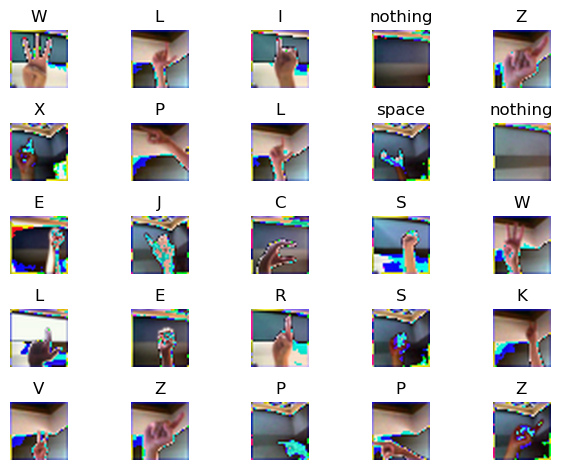

In [5]:
# displays grid of images and their labels

for i in range(25):

    image = transforms.ToPILImage()(batch[0][i])
    label = labels_names[batch[1][i].item()]
    resized_image = image.resize((256, 256), Image.LANCZOS)

    # plots the images and labels in a grid
    plt.subplot(5, 5, i + 1)
    plt.imshow(resized_image)
    plt.axis('off')
    plt.title(label )
    
plt.tight_layout()

In [6]:

# TODO: I think this is getting accuracy on a single batch, should avg those out
def get_accuracy(model,test_loader):
    """ Tests the model's accuracy """
    
    #sets model to eval mode
    model.eval()
    correct = 0
    
    with torch.no_grad():
        
        for data, label in test_loader:

            # model's prediction
            output = model(data)
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(label==predicted).item()
            
            
    #print(f"Accuracy: {100. * correct / len(test_loader.dataset):.2f}%")
    return round((100 * correct / len(test_loader.dataset)),2)
        


def train(model, train_loader, optimizer, loss_criteria, epoch):
    """ Trains the model parameters and returns loss and
    accuracy at each epoch
    
    Args:
    model - pytorch model to train
    train_loader - pytorch dataLoader class 
    optimizer - pytorch optimizer object
    loss_criteria - pytorch loss criteria
    epoch - what the current epoch is
    """
    
    # sets the model to training mode
    model.train()
    loss_tracker = 0
    
    # progress bar
    train_loader_iter = tqdm(train_loader, desc = f"Epoch {epoch + 1}")
    
    
    for data,label in train_loader_iter:

        # resets the gradients
        optimizer.zero_grad()
        
        # model's current prediction
        prediction = model(data)
        
        # tracks loss
        loss = loss_criteria(prediction, label)
        loss_tracker += loss.item()
        
        # calculates gradient
        loss.backward()
        optimizer.step()
    
    
        
    return (loss_tracker, get_accuracy(model,train_loader))
        

In [6]:
learning_rate = 0.01
epochs = 20
losses = []
accuracies = []


model = LeNet5()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
loss_criteria = nn.CrossEntropyLoss()

In [7]:
for epoch in range(epochs):
    loss,accuracy = train(model, train_loader, optimizer, loss_criteria, epoch)
    losses.append(loss)
    accuracies.append(accuracy)

Epoch 20: 100%|███████████████████████████████| 272/272 [01:02<00:00,  4.38it/s]


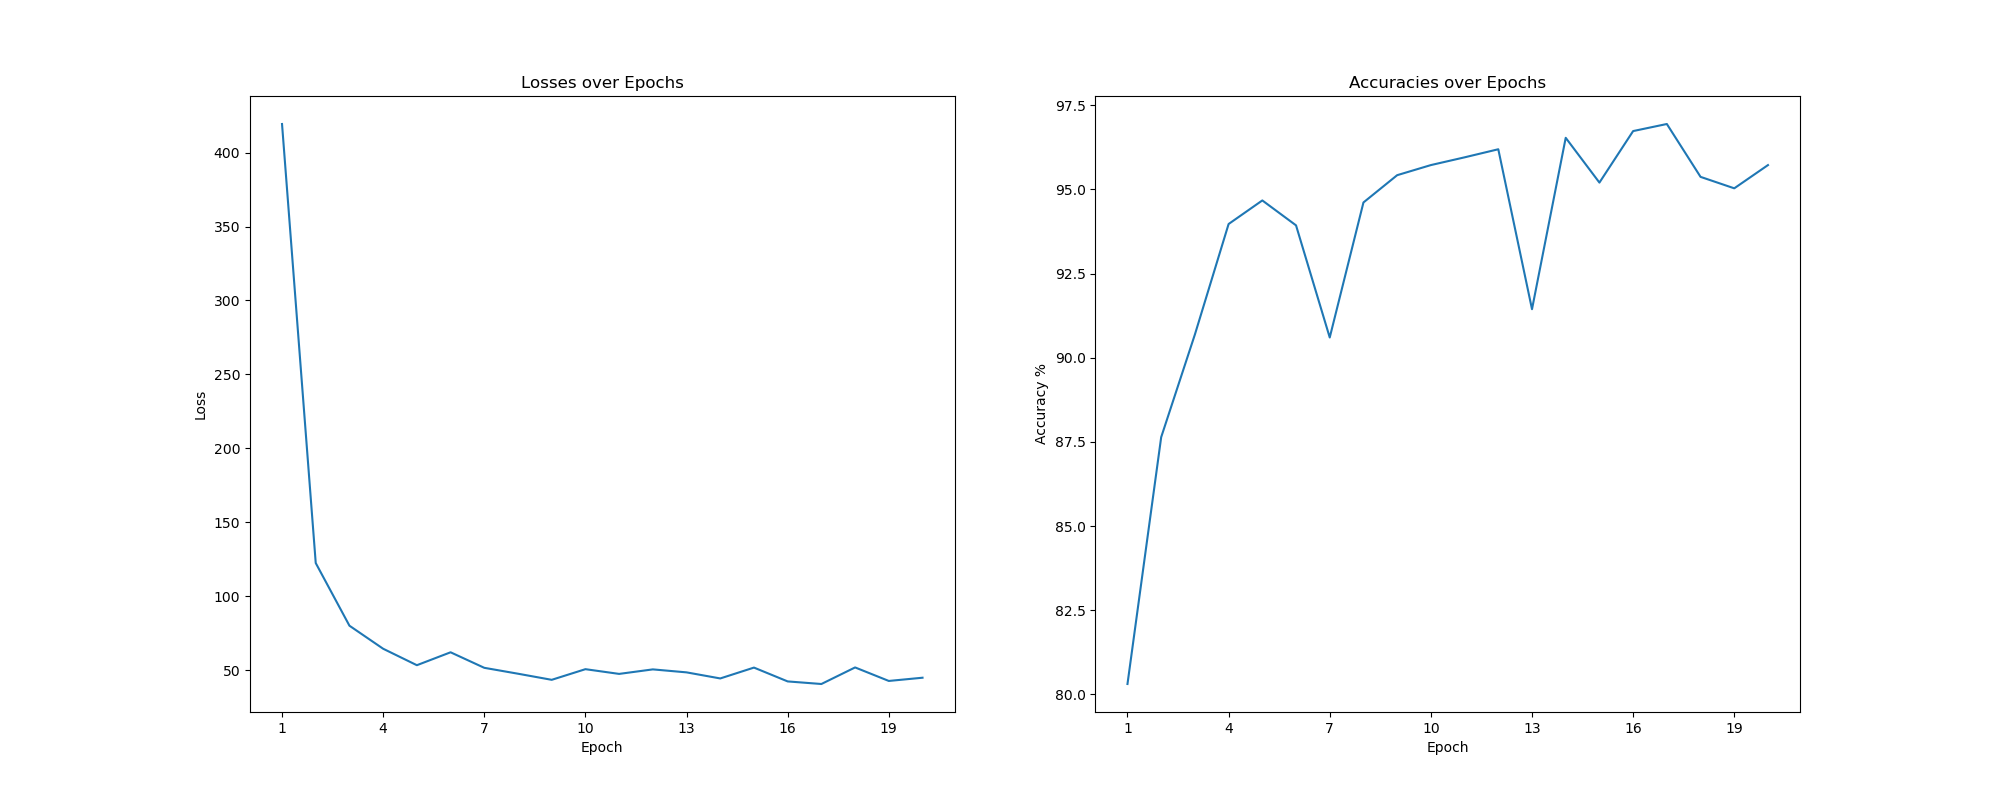

In [7]:
def make_plots(fileName):
    """ Creates a losses and accuracies plots and saves them to specified
    file name. """
    fig,ax = plt.subplots(1,2, figsize = (20,8))

    ax[0].plot(np.arange(1,epochs + 1), losses)
    ax[0].set(title = "Losses over Epochs", ylabel = "Loss", xlabel = "Epoch")
    ax[0].set_xticks(np.arange(1,epochs+1,3));

    ax[1].plot(np.arange(1,epochs + 1), accuracies)
    ax[1].set(title = "Accuracies over Epochs", ylabel = "Accuracy %", xlabel = "Epoch")
    ax[1].set_xticks(np.arange(1,epochs+1,3));

    plt.savefig(f"{fileName}.png", format="png")

# displays the plot
Img(filename="plot.png")

The code below is for testing purposes rn. Also currently the validation set is more or less used as a test so maybe we abolish the test_loader all together...

In [ ]:
save_model(model, MODEL_PATH)

In [44]:
del model

In [8]:
model = LeNet5()
load_model(model, MODEL_PATH)

<All keys matched successfully>

In [8]:
print(f"The accuracy on our validation set is: {get_accuracy(model,val_loader)}%")
print(f"The accuracy on our validation set is: {get_accuracy(model,test_loader)}%")

The accuracy on our validation set is: 95.36%
The accuracy on our validation set is: 92.86%


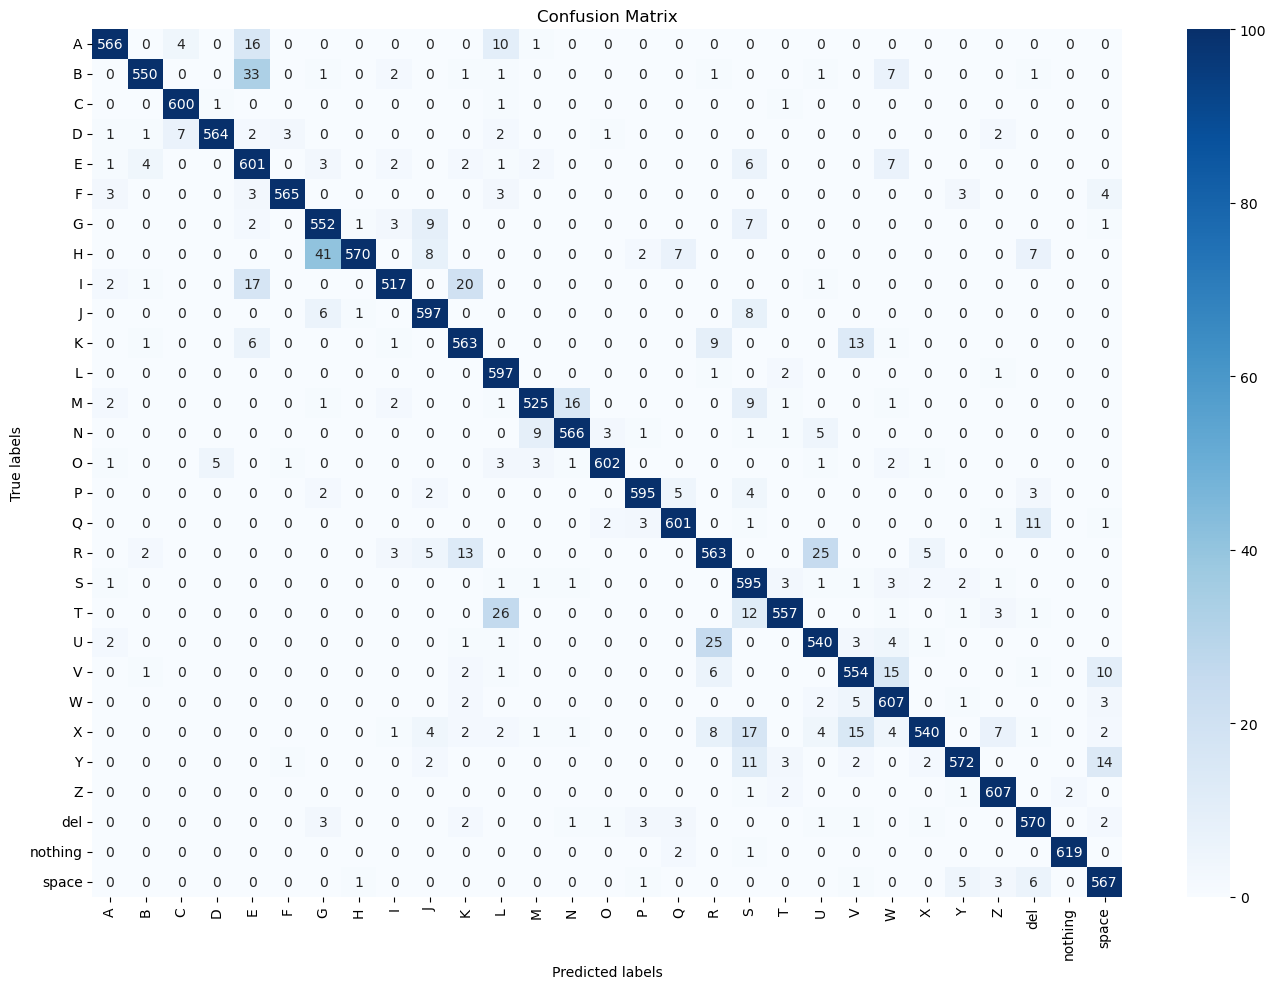

In [10]:
def create_confusion_matrix(model, test_loader):
    """ Creates a confusion matrix given a model and a dataLoader object"""
    
    # sets the model to eval mode
    model.eval()
    

    labels_list = []
    predicted_list = []
    
    
    with torch.no_grad():
    
        for data,label in test_loader:
            # fills the labels and predictions
            labels_list.extend(label.numpy())
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            predicted_list.extend(predicted.numpy())
            
    
    conf_matrix = confusion_matrix(labels_list, predicted_list)
    
    # creates a sns heatmap with the conf matrix
    plt.figure(figsize=(14,10))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', 
            xticklabels=labels_names, yticklabels=labels_names, vmax = 100)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
            
            
create_confusion_matrix(model, val_loader)

Seaborn version: 0.13.0
